# Bi-Directional GRU Model for OWQA

---
### Get the preprocessed data

In [1]:
%run ow_pre_model.ipynb

Using TensorFlow backend.


** One-hot encoding the labels in two tensors . . .
** One-hot encoding the labels in two tensors . . .
(26395, 276)
Done.


---
## Model

In [4]:
context_input = Input(shape=(c_maxlen,), dtype='int32', name='context_input')
question_input = Input(shape=(q_maxlen,), dtype='int32', name='question_input')

context_embedding = Embedding(output_dim=300, input_dim=vocabulary_size,
                         input_length=c_maxlen, name='context_embedding')(context_input)

question_embedding = Embedding(output_dim=300, input_dim=vocabulary_size, 
                         input_length=q_maxlen, name='question_embedding')(question_input)

encoded_contexts = Bidirectional(GRU(75, dropout=0.5, return_sequences=False))(context_embedding)
encoded_questions = Bidirectional(GRU(75, dropout=0.5, return_sequences=False))(question_embedding)
merge1 = concatenate([encoded_questions, encoded_contexts], axis=-1, name='merge1')

answer = Dense(c_maxlen, activation='softmax', name='answer')(merge1)


model = Model([context_input, question_input], answer)

rms = optimizers.RMSprop(lr=0.0005)
model.compile(optimizer=rms, loss='categorical_crossentropy', metrics=['acc'])


model.summary()

tb = TensorBoard(log_dir='../models_logs/ow_lstm')
mc = ModelCheckpoint('../saved_models/ow_lstm_best.h5', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit([train_data['contexts'], train_data['questions']], train_data['start_wordloc'],
                    epochs=20,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=[tb, mc])





____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
question_input (InputLayer)      (None, 36)            0                                            
____________________________________________________________________________________________________
context_input (InputLayer)       (None, 276)           0                                            
____________________________________________________________________________________________________
question_embedding (Embedding)   (None, 36, 300)       25751400    question_input[0][0]             
____________________________________________________________________________________________________
context_embedding (Embedding)    (None, 276, 300)      25751400    context_input[0][0]              
___________________________________________________________________________________________

---
## Model Evaluation

Evaluating the model . . . 

3002/3002 [==============================] - 12s 4ms/step

______________________________________________________________________________________________________________ 

                                      TRAINING LOSS AND ACCURACY PLOTS
______________________________________________________________________________________________________________ 



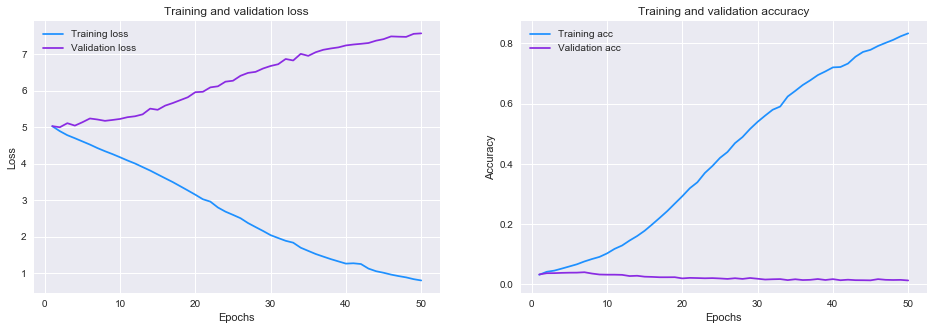

______________________________________________________________________________________________________________ 

                                         EVALUATION ON TRAINING SET
______________________________________________________________________________________________________________ 

             EM:  66.84599355938624 ;   Top2-EM:  69.54726273915514 ;   Top3-EM:  70.75203637052472 

                          loss  =  1.9067771112135266
                          acc  =  0.7317673801859235
______________________________________________________________________________________________________________ 

                                        EVALUATION ON DEVELOPMENT SET
______________________________________________________________________________________________________________ 

             EM:  1.5323117921385743 ;   Top2-EM:  2.9980013324450367 ;   Top3-EM:  4.130579613590939 

                          loss  =  7.463789250197846
                          acc  =  0.01299133

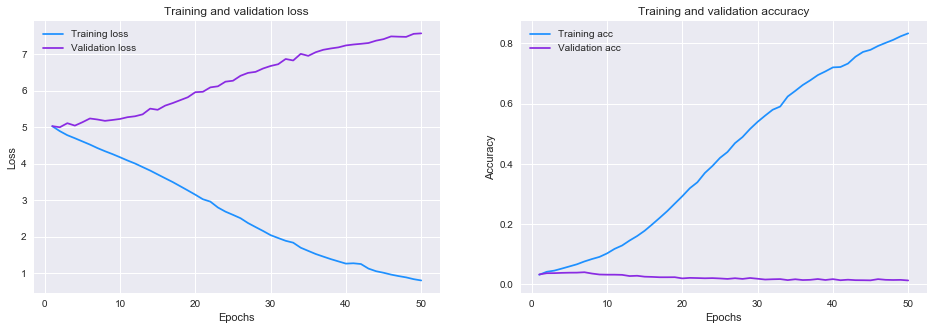

______________________________________________________________________________________________________________ 

                                         EVALUATION ON TRAINING SET
______________________________________________________________________________________________________________ 

             EM:  4.853191892403864 ;   Top2-EM:  7.084675127865126 ;   Top3-EM:  8.922144345519985 

                          loss  =  4.841913354530052
                          acc  =  0.04387194544449519
______________________________________________________________________________________________________________ 

                                        EVALUATION ON DEVELOPMENT SET
______________________________________________________________________________________________________________ 

             EM:  5.02998001332445 ;   Top2-EM:  6.962025316455696 ;   Top3-EM:  8.327781479013991 

                          loss  =  4.884708385162557
                          acc  =  0.04563624250

In [6]:
%run ../../evaluation/ow_evaluate.ipynb
saved_model = load_model('../saved_models/ow_lstm_best.h5')# load a saved model

print("Evaluating the model . . . \n")
train_data['start_pred'] = model.predict([train_data['contexts'], train_data['questions']], verbose=1)
dev_data['start_pred'] = model.predict([dev_data['contexts'], dev_data['questions']], verbose=1)

evaluation_main(train_data, dev_data, model, history.history)


print("\n\n\nEvaluating the saved best model . . . \n")
train_data['start_pred'] = saved_model.predict([train_data['contexts'], train_data['questions']], verbose=1)
dev_data['start_pred'] = saved_model.predict([dev_data['contexts'], dev_data['questions']], verbose=1)

evaluation_main(train_data, dev_data, saved_model, history.history)
